In [1]:
from embedding.parser import Parser, Rule
from embedding.schema import Schema
from embedding.encoder import Encoder
from embedding.array import array_to_tree
from embedding.structure import Struct
import numpy as np
import matplotlib.pyplot as plt



def random_parse_tree(depth):
    rule_num = np.random.choice([0,1,2])
    
    if depth == 1 or rule_num == 0:
        return 'E', {'arg1': 'L', 'arg2': 'R'}

    if rule_num == 1:
        return 'E', {
            'arg1': 'L', 
            'arg2': random_parse_tree(depth - 1), 
            'arg3': 'R'}
    
    if rule_num == 2:
        return 'E', {
            'arg1': random_parse_tree(depth - 1), 
            'arg2': random_parse_tree(depth - 1) }
    
def deparse(st):
    if isinstance(st, Struct):
        st = st.to_array()
    res = []
    lab = st[0]
    attr = st[1] if len(st) == 2 else {}
    if lab == 'E':
        res += deparse(attr['arg1'])
        res += deparse(attr['arg2'])
        if len(attr) == 3:
            res += deparse(attr['arg3'])
    else:
        res.append(lab)
        
    return res


def validate(st):
    if isinstance(st, Struct):
        st = st.to_array()
    
    try:    
        if st in ['L', 'R']:
            return True
        if isinstance(st, str):
            return False
        
        if st[0] == 'E' and len(st[1]) == 2:
            a1 = st[1]['arg1']
            a2 = st[1]['arg2']
            if a1 == 'L' and a2 == 'R':
                return True
            if a1[0] == 'E' and a2[0] == 'E':
                return validate(a1) and validate(a2)
            return False
        if st[0] == 'E' and len(st[1]) == 3:
            a1 = st[1]['arg1']
            a2 = st[1]['arg2']
            a3 = st[1]['arg3']
            if a1 == 'L' and a2[0] == 'E' and a3 == 'R':
                return validate(a2)
            return False
        return False
    except KeyError:
        return False

In [2]:

def test_parse(seq, enc, max_depth):
    seq_vec = [x for x in map(enc, seq)]

    y = p.parse(seq_vec)
    
    tr = en.decode(y[0], max_depth)
    if tr is None:
        return False
    tr = tr.to_strings()
    
    return validate(tr) and deparse(tr) == seq


def add_trees(trees, n, depth, lim, max=10):
    ln0 = len(trees)
    i = 0
    while len(trees) < ln0 + n:
        while True and i < max*n:
            tree = random_parse_tree(depth)
            if len(deparse(tree)) <= lim:
                trees[str(tree)] = tree
                break    
            i += 1

In [3]:
def get_trees(n):
    trees = dict()

    add_trees(trees, n, 5, 20)
    add_trees(trees, 2*n, 6, 30)
    add_trees(trees, 3*n, 7, 35)
    #add_trees(trees, n, 8, 35)
    
    return trees

In [4]:
random_parse_tree(4)

('E',
 {'arg1': 'L',
  'arg2': ('E',
   {'arg1': 'L',
    'arg2': ('E',
     {'arg1': 'L', 'arg2': ('E', {'arg1': 'L', 'arg2': 'R'}), 'arg3': 'R'}),
    'arg3': 'R'}),
  'arg3': 'R'})

150

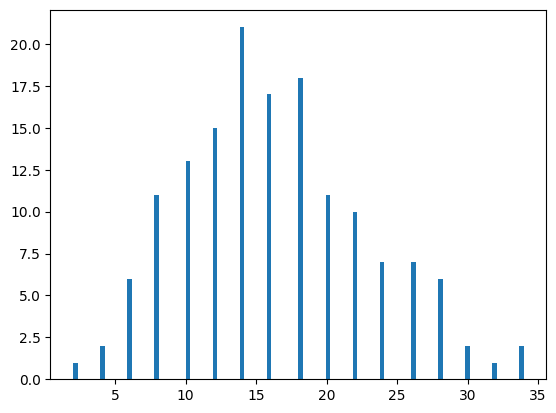

In [5]:
t = get_trees(25)
x= [len(deparse(t)) for t in t.values()]
plt.hist(x,bins=100)
len(t)

In [0]:
good = 0
bad = 0
res = []

In [9]:
import pickle
with open('res_parse.pkl', 'rb') as file:
    res = pickle.load(file)
good = 0
bad = 0

In [ ]:

dims = [x for x in range(2000,100,-20)]
for dim in dims:
    trees = get_trees(5)
    sc = Schema(labels=['L', 'R', 'E'],
                attributes=['next', 'arg1', 'arg2', 'arg3'])

    en = Encoder(schema=sc, dim=dim, seed=42)
    def enc(a):
        return en.encode(array_to_tree(a))

    e = enc(['E'])

    r1 = Rule(length=2,
              pattern=enc(['L', 'R']),
              replacement=e)

    r2 = Rule(length=3,
             pattern=enc(['L', 'E', 'R']),
              replacement=e)

    r3 = Rule(length=2,
              pattern=enc(['E', 'E']),
              replacement=e)

    p = Parser(schema=sc,
               rules=[r1, r2, r3],
               next_a=en.attr_emb[sc.attr_to_ind['next']],
               args=[en.attr_emb[sc.attr_to_ind[x]] for x in ['arg1', 'arg2', 'arg3']])

    for t in trees.values():
        ld = len(deparse(t))
        ret = test_parse(deparse(t), enc, 7)
    
        if ret:
            good += 1
        else:
            bad += 1
        
        res.append((dim, ld, ret))
        print(dim, ld, good, bad)

2000 4 103 1998
2000 2 104 1998
2000 10 105 1998
2000 8 106 1998
2000 12 107 1998
2000 14 108 1998
2000 14 109 1998
2000 22 110 1998
2000 14 111 1998
2000 18 112 1998
2000 6 113 1998
2000 8 114 1998
2000 6 115 1998


N=14335


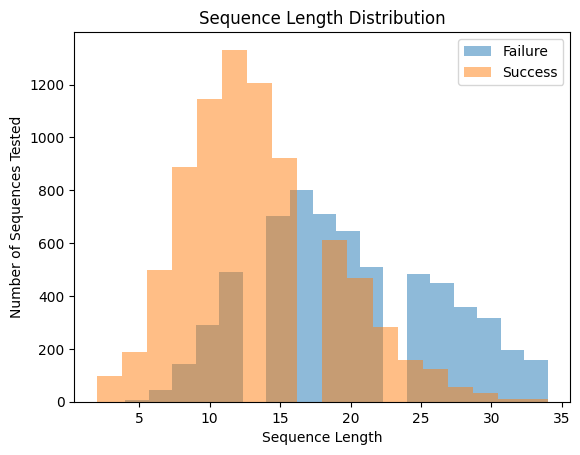

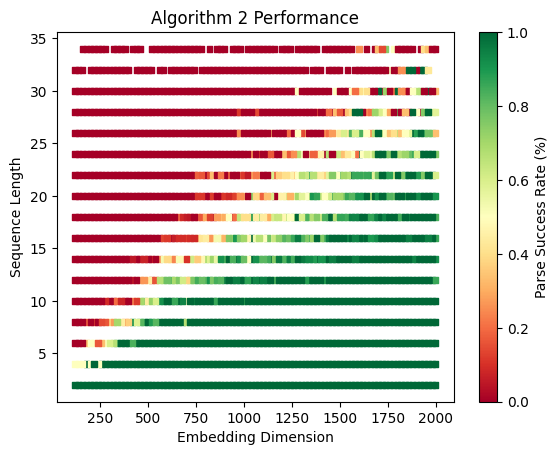

In [11]:
rr = np.array(res)

agg = []
keys = {(r[0], r[1]) for r in rr}
for d, l in keys:
    agg.append((d, l, np.mean(rr[(rr[:,0]==d) & (rr[:,1]==l),2])))
agg = np.array(agg)

plt.hist(rr[rr[:,2]==0,1],bins=18,alpha=0.5)
plt.hist(rr[rr[:,2]==1,1],bins=18,alpha=0.5)
plt.title('Sequence Length Distribution')
plt.ylabel('Number of Sequences Tested')
plt.xlabel('Sequence Length')
plt.legend(['Failure','Success'])

plt.figure()
plt.scatter(agg[:,0], agg[:,1], c=agg[:,2], cmap='RdYlGn', s=15, marker='s')
plt.colorbar().set_label('Parse Success Rate (%)')
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Length')
plt.title('Algorithm 2 Performance')

plt.savefig('rand_parse2.png', dpi=300)
print(f'N={rr.shape[0]}')

In [80]:
np.save('parses2.npy', rr)

In [82]:
# save res in a pickle
import pickle
with open('res_parse.pkl', 'wb') as f:
    pickle.dump(res, f)

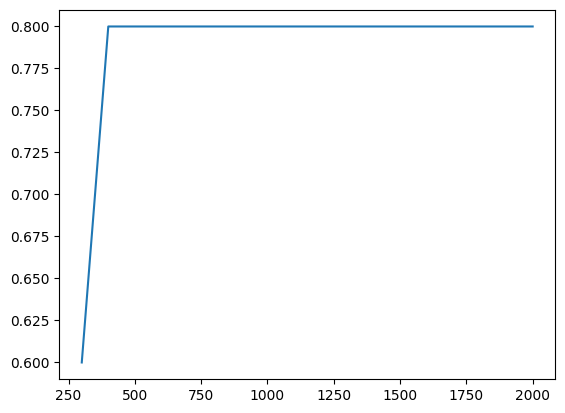

In [54]:
x = agg[agg[:,1]==6,]
x.sort(axis=0)
plt.plot(x[:,0], x[:,2])

In [40]:
x